# Simulate Enhanced TITAN framework (Han et al. 2009)
This notebook run the algorithm of ETitan (2009), including three stages:
1. **Identification:** use Morphological-based algorithm to identify storm cells.
2. **Tracking:**
    - Use overlapping of forecasting version to detect intermediately the absolute matches of storms.
    - Use Hungarian optimization to match: using differencei in volumes and centroid movement.
3. **Forecasting:** difference from the original TITAN, Enhanced TITAN use TREC directly from time frame $t-1$ to $t$ to estimate for the velocity (do not use linear interpolation)

*In some sense, tracking step is only used for estimate other parameters change: area (VIL and Top height are skipped in 2D simplication)*

100%|██████████| 5/5 [00:02<00:00,  1.85it/s]

Total DBZ maps processed: 5. Shape of each DBZ map: (505, 1220)
----------------------------------------


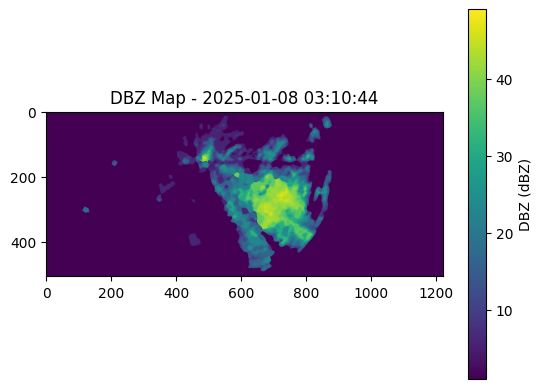

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm

from src.utils import windy_preprocessing_pipeline, process_image

SOURCE_PATH = "data/images/philippines_13.269_123.832"
img_paths = [os.path.join(SOURCE_PATH, img_name) for img_name in sorted(os.listdir(SOURCE_PATH)) if img_name.endswith('.png')][:5]

dbz_maps: list[tuple[np.ndarray, datetime]] = []

for img_path in tqdm(img_paths):
    img, time_frame = process_image(img_path)
    dbz_map = windy_preprocessing_pipeline(img)
    dbz_maps.append((dbz_map, time_frame))

print(f"Total DBZ maps processed: {len(dbz_maps)}. Shape of each DBZ map: {dbz_maps[0][0].shape}")
print("-"*40)

# Visualize first DBZ map
plt.imshow(dbz_maps[0][0], cmap='viridis')
plt.colorbar(label='DBZ (dBZ)')
plt.title(f"DBZ Map - {dbz_maps[0][1]}")
plt.show()

## 1. Identify storms

100%|██████████| 5/5 [00:00<00:00, 59.50it/s]


----------------------------------------


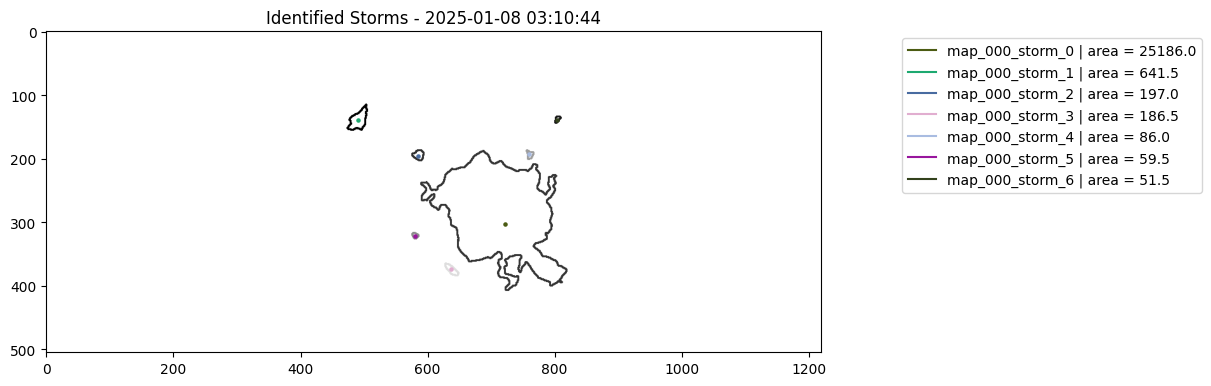

In [ ]:
from src.cores.base import StormObject, StormsMap
from src.model.etitan_original import ETitanPrecipitationModel
from src.identification import MorphContourIdentifier, SimpleContourIdentifier
from src.utils import convert_polygons_to_contours

DBZ_THRESHOLD = 30  # dBZ
FILTER_AREA = 50  # pixels      ==> Less than 50 pixels will be filtered out

# identifier = MorphContourIdentifier()
simple_identifier = SimpleContourIdentifier()
model = ETitanPrecipitationModel(identifier=simple_identifier)
storms_maps: list[StormsMap] = []

for idx, (dbz_map, time_frame) in tqdm(list(enumerate(dbz_maps))):
    storms_map = model.identify_storms(dbz_map, time_frame, map_id=f"map_{idx:03d}", threshold=DBZ_THRESHOLD, filter_area=FILTER_AREA)
    # storms_map = simple_identifier.identify_storm(dbz_map, threshold=DBZ_THRESHOLD, filter_area=FILTER_AREA)
    storms_maps.append(storms_map)

# print(f"Total storms to be identified across all maps: {sum(len(sm.storms) for sm in storms_maps)}")
print("-"*40)

# Visualize storms with contours on the first DBZ map
storms_map = storms_maps[0]
plt.figure(figsize=(10, 8))
# blank_image, _ = process_image(img_paths[0])
blank_image = np.ones_like(dbz_maps[0][0], dtype=np.uint8) * 255

for storm in storms_map.storms:
    x_centroid, y_centroid = storm.centroid
    
    plt.plot([], [], color=np.array(storm.contour_color)/255.0, label=f"{storm.id} | area = {storm.contour.area:.1f}")
    plt.scatter(x_centroid, y_centroid, color=np.array(storm.contour_color)/255.0, s=5)
    cv2.drawContours(blank_image, convert_polygons_to_contours([storm.contour]), -1, storm.contour_color, thickness=2)  # Draw contour in red

plt.imshow(blank_image, cmap='grey')
plt.title(f"Identified Storms - {storms_map.time_frame}")
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0))
plt.savefig("data/output/sample_identified_storms.png", bbox_inches='tight')
plt.show()

## 2. Matching and Tracking

In [ ]:
# model = ETitanPrecipitationModel(identifier=identifier)
# model.processing_map(storms_maps[0])  # Process the first storms map to initialize tracking

# for storm in storms_maps[0].storms:
#     print(f"Storm ID: {storm.id}, Centroid: {storm.centroid}, Area: {storm.contour.area:.2f}")
